# Scattering

## Aim

Prototype scatter normalization methods

In [1]:
import os
import math
from functools import lru_cache
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sxfst import utils

@lru_cache
def find(path):
    return [i for i in os.popen(f'find {path}').read().split('\n') if os.path.exists(i)]

platereader_files = find('../lab -name *CSV')

data = []
for i in tqdm(platereader_files):
    data.append(utils.parse(i))

100%|██████████████████████████████████████| 159/159 [00:11<00:00, 13.27it/s]


## All Traces

In [2]:
df = pd.concat(data).fillna(0)
df = df.sub(df.loc[:,800], axis=0)
df

,220,221,222,223,224,225,226,227,228,229,...,791,792,793,794,795,796,797,798,799,800
A1,1.368,1.536,1.692,3.260,2.090,1.857,1.871,2.246,2.145,2.382,...,0.000,0.002,0.004,0.006,0.006,0.007,0.005,0.004,0.000,0.0
B1,1.965,1.477,1.568,3.484,3.484,1.861,2.070,2.724,2.687,3.033,...,-0.001,0.000,0.002,0.004,0.003,0.005,0.004,0.002,0.000,0.0
C1,1.555,1.624,1.516,3.484,2.015,1.868,2.056,2.340,2.198,2.337,...,-0.001,0.001,0.004,0.004,0.005,0.005,0.004,0.003,0.000,0.0
D1,1.520,1.573,2.477,3.485,2.960,1.957,2.338,2.382,2.389,3.020,...,0.000,0.001,0.003,0.005,0.006,0.006,0.006,0.003,0.002,0.0
E1,3.480,1.919,1.580,2.392,2.935,1.643,1.937,2.605,2.470,2.676,...,0.000,0.001,0.003,0.004,0.004,0.006,0.004,0.003,0.001,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L24,3.267,2.185,1.722,2.174,2.192,2.238,2.790,3.413,3.413,3.413,...,0.001,-0.001,-0.002,0.001,0.001,0.000,0.001,0.001,0.001,0.0
M24,1.784,1.576,2.283,3.431,2.749,2.136,3.431,3.431,3.431,2.717,...,0.000,-0.001,-0.003,0.000,-0.001,0.000,0.000,0.000,0.000,0.0
N24,1.955,2.385,2.660,2.201,2.028,2.047,3.097,3.436,3.436,3.436,...,0.001,0.000,-0.002,0.001,0.000,0.001,0.001,0.001,0.002,0.0
O24,1.725,1.662,1.533,2.185,2.266,2.718,2.382,3.136,3.085,3.445,...,0.000,0.000,-0.001,0.001,0.001,-0.001,0.000,0.001,0.000,0.0


## PCA not useful

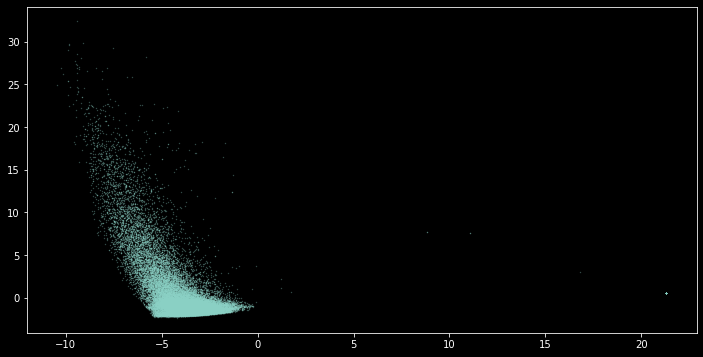

In [3]:
from sklearn.decomposition import PCA

pca = PCA()

decomp = pca.fit_transform(df.fillna(0))

plt.figure(figsize=(12,6))
plt.scatter(decomp[:,0], 
            decomp[:,1],
            s=0.1,
            alpha=0.5)

plt.show()

## Esitmated scatter

[https://www.youtube.com/watch?v=8eTOtwbVzDQ](https://www.youtube.com/watch?v=8eTOtwbVzDQ)

8 mins

$ A_{scatter, \lambda} = \log{\frac{1}{1 - (f(\lambda^{-4}))}}  + A_0 $

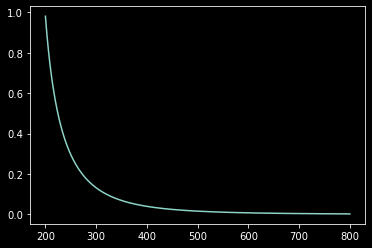

In [4]:
def rayest(x,f):
    return np.log(1/(1 - (f*(x**-4))))

def plot(fn):
    x = np.linspace(200,800,600)
    y = fn(x)
    plt.plot(x,y)
    plt.show()
    
plot(lambda x : rayest(x,f=1e9))

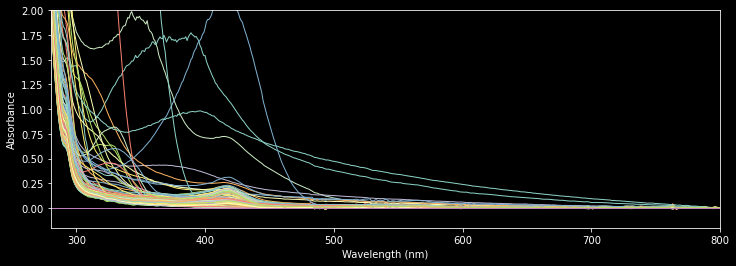

In [5]:
def plot_traces(df):
    assert isinstance(df, pd.DataFrame)
    figure = plt.figure(figsize=(12,4))
    for i, _ in enumerate(df.index):
        row = df.iloc[i,:]
        plt.plot(row.index, 
                 row,
                 lw=1,
                 )
    plt.xlim(280,800)
    plt.ylim(-0.2, 2)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    plt.show()



plot_traces(df.sample(128))

In [137]:
import torch
import torch.nn as nn
from torch.optim import Adam

df_ = df.loc[:,600:] # getting rid of the saturated part of the trace
x = torch.from_numpy(df_.values)
wavel = torch.from_numpy(df_.columns.astype(float).values)

In [138]:
from einops import rearrange, repeat

def rayestt(wavel, f, s1=1e9):
    assert len(wavel.shape) == 1
    if len(f.shape) == 2:
        #f = rearrange(f, 'i j -> (i j)')
        n = f.shape[0]
    else:
        n = 1
    wavel = repeat(wavel, 'i -> j i', j=n)
    yh_ = torch.log(1/(1 - (f*(wavel**-4)))) * s1
    #return rearrange(yh_, 'i j -> j i')
    return yh_

x_ = x[0:8,:]
f = torch.ones((x_.shape[0],1), requires_grad=True)
yh = rayestt(wavel,f)

print(f.shape, x_.shape, wavel.shape, yh.shape)
print(x_.shape, yh.shape)
loss_fn(x_, yh)

torch.Size([8, 1]) torch.Size([8, 201]) torch.Size([201]) torch.Size([8, 201])
torch.Size([8, 201]) torch.Size([8, 201])


tensor(2.4717e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>)

TypeError: exp(): argument 'input' (position 1) must be Tensor, not int

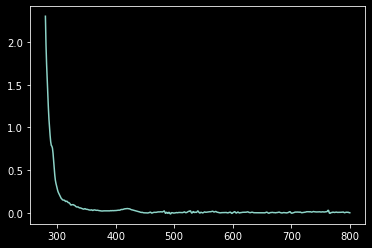

In [136]:
plt.plot(wavel, x_[0,:] )
#fn = lambda w : torch.exp( w**-4)
#def fn(wavel, n=1, d=1e-6):
#    return (2*torch.pi / wavel * 1e2)**4 #* ((n**2 -1)/(n**2 + 2))**2 * (d/2)**6
def fn(wavel, n=10, S=1):
    #return (n/wavel * 1e2)**4 * 1e-3
    return torch.exp(torch.-S*n)

plt.plot(wavel, fn(wavel))
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:01<00:00, 609.76it/s, loss=1.56e-5]


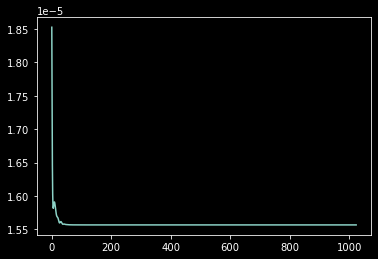

In [139]:
x_ = x[:16,:]

f = torch.ones((x_.shape[0],1), requires_grad=True)

# one param / trace
#if len(x_.shape) == 1:
#    f = torch.zeros(1, requires_grad=True)
#else:
#    f = torch.zeros(x_.shape[0], requires_grad=True)
    
opt = Adam([f],lr=1e-1)
loss_fn = nn.MSELoss()


l = []

with tqdm(range(2**10)) as bar:
    for _ in bar:
        yh = rayestt(wavel,f)
        loss = loss_fn(x_, yh)
        loss.backward()
        opt.step()
        opt.zero_grad()
        bar.set_postfix({'loss':(L:=loss.detach().item())})
        l.append(L)
        
plt.plot(l)
plt.show()

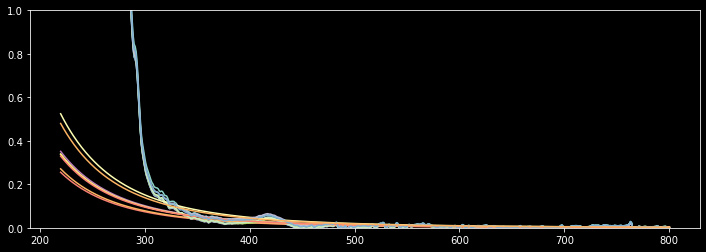

In [155]:
plt.figure(figsize=(12,4))
for i, j in zip(range(8), f):
    plt.plot(df.columns, df.iloc[i,:])
    plt.plot(df.columns, rayestt(torch.from_numpy(df.columns.astype(float).values), j).detach().reshape(-1))
plt.ylim(0,1)
plt.show()

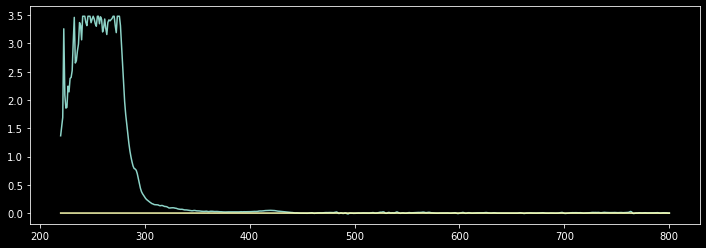

In [199]:
plt.figure(figsize=(12,4))
plt.plot(df.columns, df.iloc[0,:])
invsq = lambda x : np.log(x.astype(float))**-4
plt.plot(df.columns, invsq(df.columns))
plt.show()

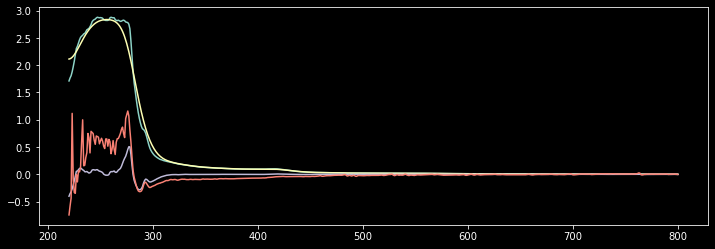

In [211]:
from scipy.ndimage import gaussian_filter1d

plt.figure(figsize=(12,4))
plt.plot(m:=df.mean(axis=0))
plt.plot(df.columns, sm:=gaussian_filter1d(m, sigma=8))
plt.plot(m-sm)
plt.plot(df.iloc[0,:]-sm)
plt.show()

In [251]:
def parse(path):
    # find start of table
    with open(path) as f:
        data = f.read().splitlines()
    for i,j in enumerate(data):
        if j.count(',') > 16:
            #del data # free up mem
            break
    df = pd.read_csv(path, skiprows=i+1)
    if 'Unnamed: 0' in df.columns and 'Unnamed: 1' in df.columns:
        wells = [f'{i}{j}' for i, j in zip(df['Unnamed: 0'],
                                           df['Unnamed: 1'])]
    elif 'Unnamed: 0' in df.columns and 'Unnamed: 1' not in df.columns:
        wells = [f'{i[0]}{int(i[1:])}' for i in df['Unnamed: 0'].to_list()]
    else:
        raise Warning(":'(")
        
    for i in df.columns:
        if 'Unnamed' in i or 'Wavelength' in i:
            df = df.drop(i, axis=1)
    df.index = wells
    df.columns = df.columns.astype(int)
    return df

parse('../lab/00.0/platereader/2022-02-28-s48-r1-4-prot-cold.csv.CSV')
parse('../lab/00.1/platereader/2022-03-02-00.1-prot-30deg-mtrx.CSV')

6
390


EmptyDataError: No columns to parse from file

In [253]:
pd.read_csv('../lab/00.1/platereader/2022-03-02-00.1-prot-30deg-mtrx.CSV', skiprows=4)

,,,Absorbance
Well,Content,Well Scan: Average (450),NaN
A01,Sample X1,0.3,NaN
A02,Sample X2,0.3,NaN
A03,Sample X3,0.4,NaN
A04,Sample X4,0.3,NaN
...,...,...,...
P20,Sample X380,0.3,NaN
P21,Sample X381,0.4,NaN
P22,Sample X382,0.3,NaN
P23,Sample X383,0.3,NaN


In [249]:
for i in tqdm(platereader_files):
    try:
        df = parse(i)
        if df is None:
            print(i, 'None')
    except:
        print(i)

 83%|██████████████████████████████████████████████████████████▉            | 132/159 [00:05<00:01, 26.76it/s]

../lab/00.1/platereader/2022-03-02-00.1-prot-30deg-mtrx.CSV


100%|███████████████████████████████████████████████████████████████████████| 159/159 [00:06<00:00, 23.03it/s]


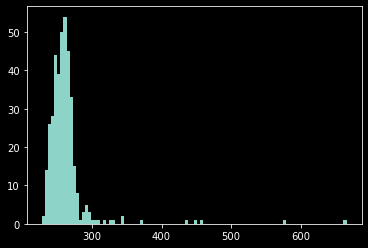

In [259]:
plt.hist(df.sum(axis=1),
         bins=100)
plt.show()